
# Cell phenotyping

Hyperspectral unmixing of Raman spectroscopic data to analyse the biomolecular composition of cells. Data from [1]_.

## Prerequisites


In [2]:
import ramanspy
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import random

In [9]:
plt.rcdefaults()

Set random seed for reproducibility



In [3]:
random.seed(12345)

## Data loading
We load the data corresponding to THP-1 cells from [1]_ and select the first cell volume.



In [5]:
dir_ = r'../data/kallepitis_data'

volumes = ramanspy.datasets.volumetric_cells(cell_type='THP-1', folder=dir_)

# select the first volume
volume = volumes[0]

## Preprocessing
We define a preprocessing pipeline to apply to the volume.



In [6]:
preprocessing_pipeline = ramanspy.preprocessing.Pipeline([
    ramanspy.preprocessing.misc.Cropper(region=(700, 1800)),
    ramanspy.preprocessing.despike.WhitakerHayes(),
    ramanspy.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
    ramanspy.preprocessing.baseline.ASLS(),
    ramanspy.preprocessing.normalise.MinMax(pixelwise=False),
])

preprocessed_volume = preprocessing_pipeline.apply(volume)

Visualising the effect of plotting.



In [7]:
selected_image_layer = 5
selected_spectrum_index = (15, 25, selected_image_layer)

bands = [789, 1008, 1303]
band_components = ['DNA', 'Protein', 'Lipids']

labels = [f'{comp}\n{band} cm$^{{{-1}}}$' for band, comp in zip(bands, band_components)]

Data before preprocessing.



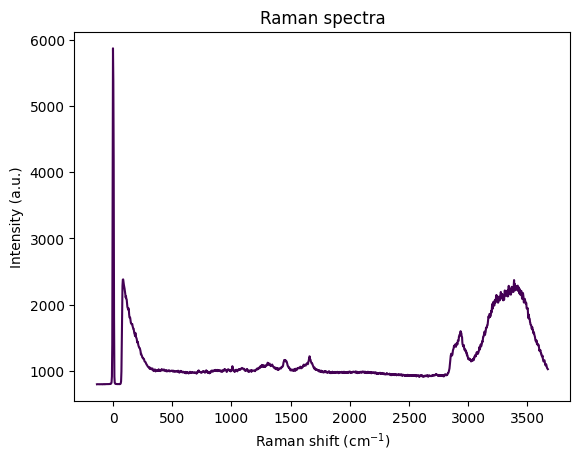

In [10]:
ax = ramanspy.plot.spectra(volume[selected_spectrum_index])

Data before preprocessing with fingerprint region highlighted.



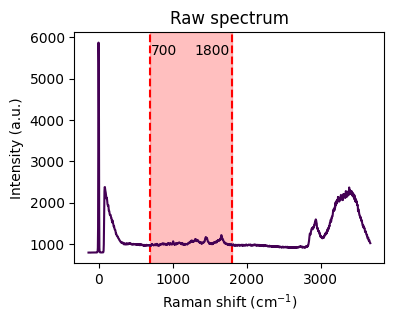

In [22]:
plt.subplots(figsize=(4, 3))

ax = ramanspy.plot.spectra(volume[selected_spectrum_index], title="Raw spectrum")
ax.axvspan(700, 1800, alpha=0.25, color='red', zorder=0)

ax.axvline(700, linestyle='--', c='red', zorder=0)
ax.text(700, .9, 700, transform=ax.get_xaxis_transform())
ax.axvline(1800, linestyle='--', c='red', zorder=0)
ax.text(1300, .9, 1800, transform=ax.get_xaxis_transform())
plt.show()

The raw data from the fingerprint region.



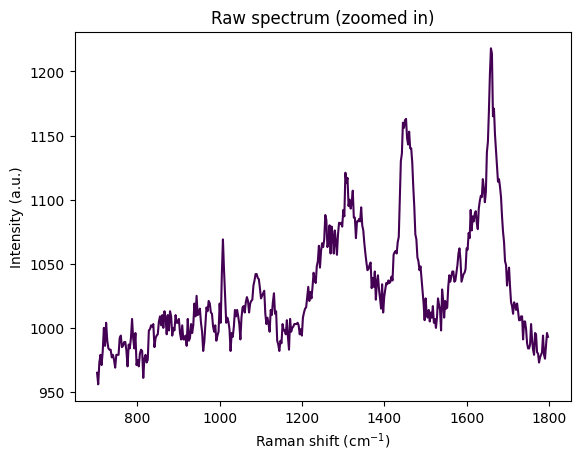

In [44]:
cropped = ramanspy.preprocessing.misc.Cropper(region=(700, 1800)).apply(volume[selected_spectrum_index])

ax = ramanspy.plot.spectra(cropped, title="Raw spectrum (zoomed in)")

Fingerprint region data after preprocessing.



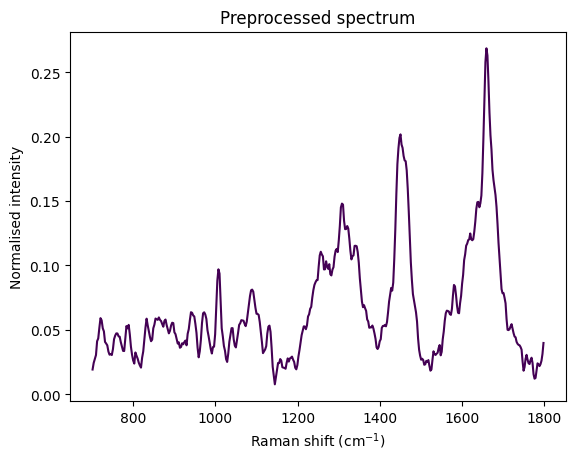

In [45]:
ax = ramanspy.plot.spectra(preprocessed_volume[selected_spectrum_index], title="Preprocessed spectrum", ylabel="Normalised intensity")

Plotting spectral slices across relevant bands corresponding to biomolecular components, such as DNA, protein and lipids.



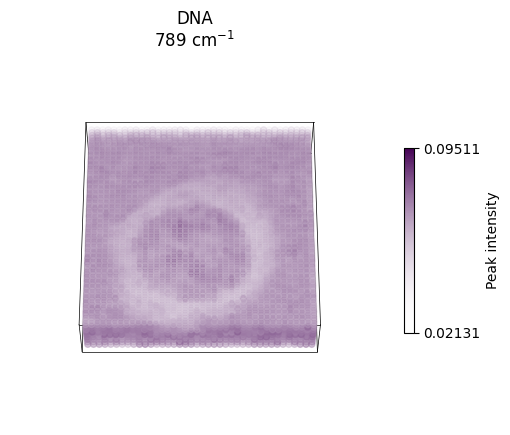

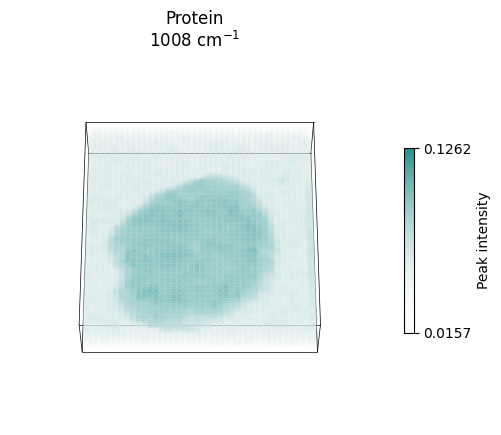

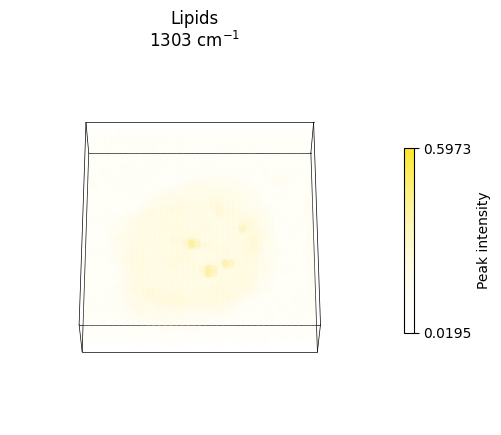

In [46]:
axs = ramanspy.plot.volume([preprocessed_volume.band(band) for band in bands], title=labels)

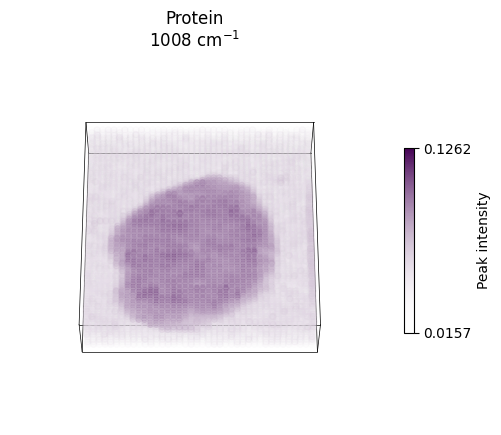

In [47]:
ax = ramanspy.plot.volume(preprocessed_volume.band(bands[1]), title=labels[1])

[<Axes: title={'center': 'DNA\n789 cm$^{-1}$'}>,
 <Axes: title={'center': 'Protein\n1008 cm$^{-1}$'}>,
 <Axes: title={'center': 'Lipids\n1303 cm$^{-1}$'}>]

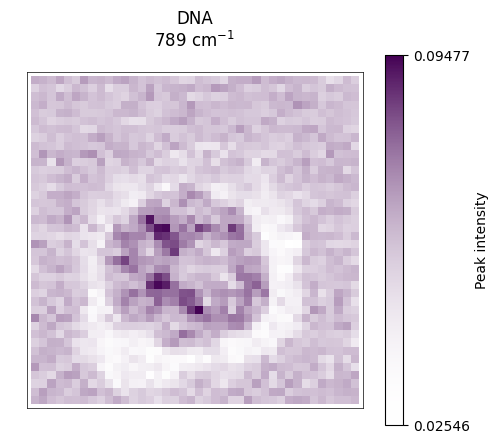

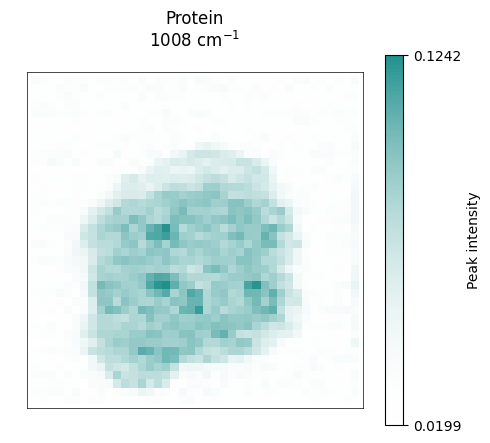

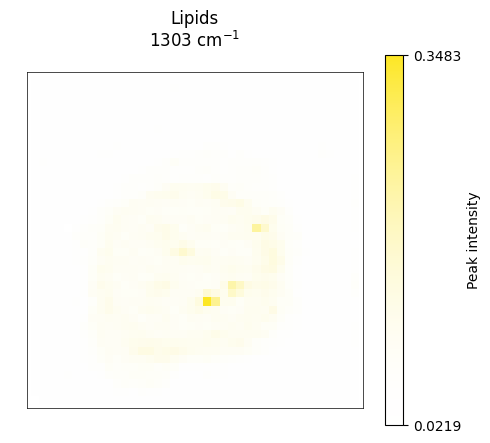

In [48]:
ramanspy.plot.image([preprocessed_volume.layer(selected_image_layer).band(band) for band in bands], title=labels)

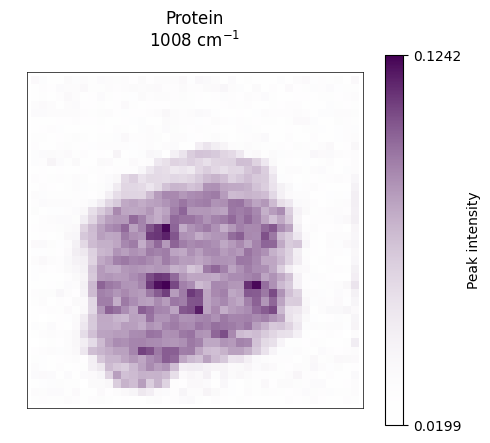

In [49]:
ax = ramanspy.plot.image(preprocessed_volume.layer(selected_image_layer).band(bands[1]), title=labels[1])

## Spectral unmixing
We use the N-FINDR [2]_ algorithm to unmix the volume into endmembers and FCLS [3]_ to derive the corresponding abundance maps.



In [50]:
nfindr_unmixer = ramanspy.analysis.unmix.NFINDR(n_endmembers=5)

In [51]:
abundance_maps, endmembers = nfindr_unmixer.apply(preprocessed_volume)

## Plotting results
Plotting the derived endmembers.



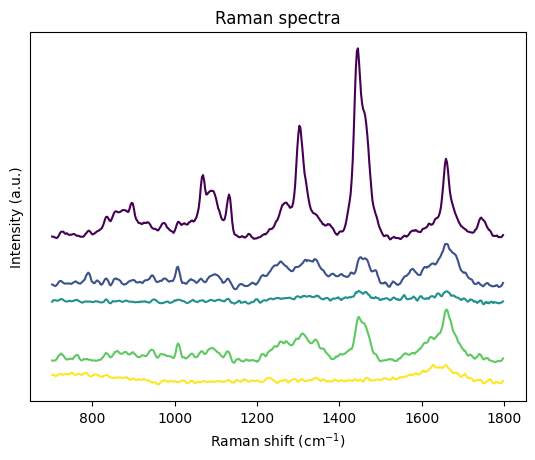

In [52]:
ax = ramanspy.plot.spectra(endmembers, wavenumber_axis=preprocessed_volume.spectral_axis, plot_type='single stacked')

Plotting a selection of endmembers that are representative of the different biomolecular components with relevant
peaks used to identify the components highlighted.



In [53]:
selected_indices = [0, 1, 3, 4]
labels_ = ['Lipids', 'Nucleus', 'Cytoplasm', 'Background']

selected_endmembers = [endmembers[i] for i in selected_indices]
selected_abundances = [abundance_maps[i] for i in selected_indices]

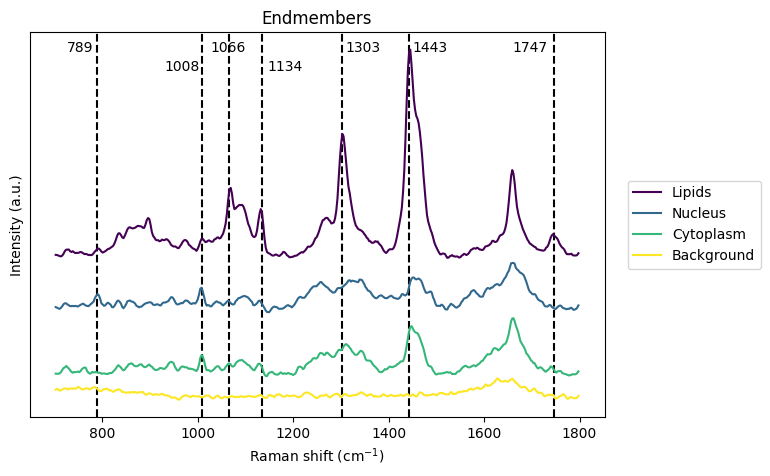

In [54]:
plt.figure(figsize=(10, 5))

ax = ramanspy.plot.spectra(selected_endmembers, wavenumber_axis=preprocessed_volume.spectral_axis, plot_type='single stacked', label=labels_, title='Endmembers')

peaks = [789, 1008, 1066, 1134, 1303, 1443, 1747]

ax.axvline(789, linestyle='--', c='black', zorder=0)
ax.text(725, .95, 789, transform=ax.get_xaxis_transform())

ax.axvline(1008, linestyle='--', c='black', zorder=0)
ax.text(930, .9, 1008, transform=ax.get_xaxis_transform())

ax.axvline(1066, linestyle='--', c='black', zorder=0)
ax.text(1027, .95, 1066, transform=ax.get_xaxis_transform())

ax.axvline(1134, linestyle='--', c='black', zorder=0)
ax.text(1145, .9, 1134, transform=ax.get_xaxis_transform())

ax.axvline(1303, linestyle='--', c='black', zorder=0)
ax.text(1310, .95, 1303, transform=ax.get_xaxis_transform())

ax.axvline(1443, linestyle='--', c='black', zorder=0)
ax.text(1450, .95, 1443, transform=ax.get_xaxis_transform())

ax.axvline(1747, linestyle='--', c='black', zorder=0)
ax.text(1660, .95, 1747, transform=ax.get_xaxis_transform())
plt.show()

Plotting the abundance maps corresponding to the selected endmembers.



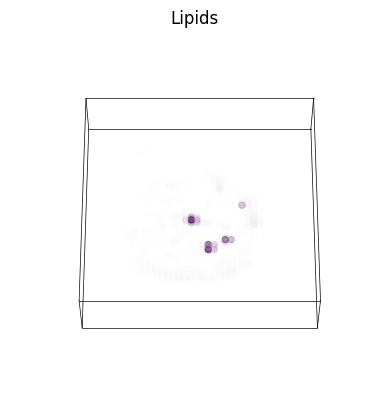

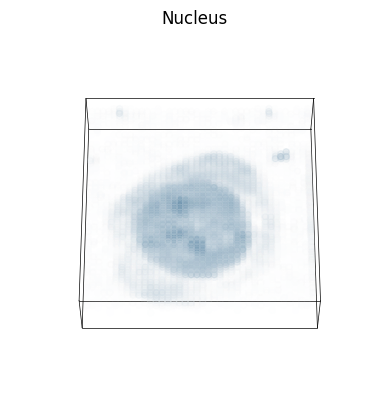

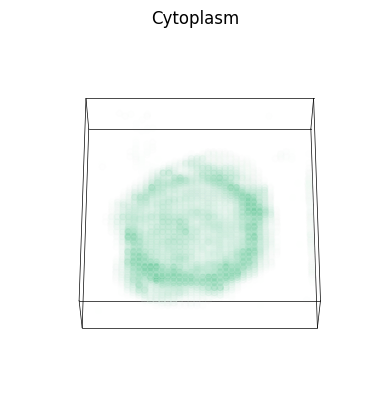

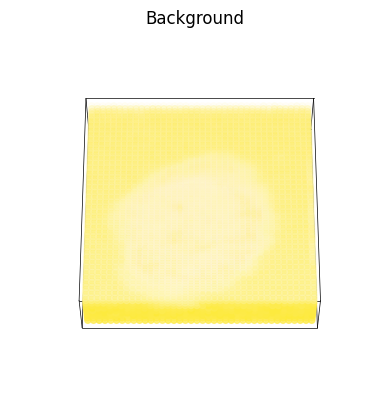

In [55]:
axs = ramanspy.plot.volume(selected_abundances, title=labels_, cbar=False)

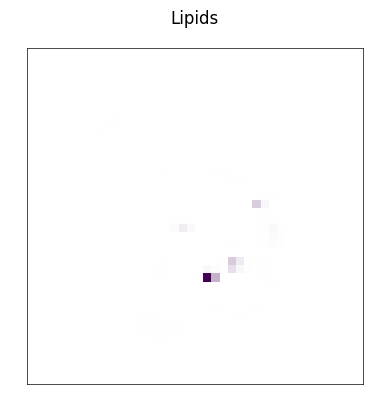

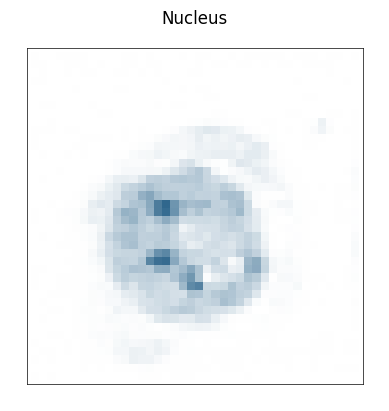

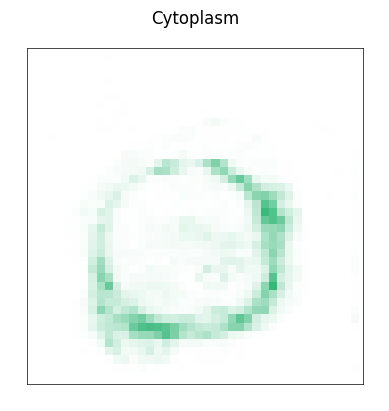

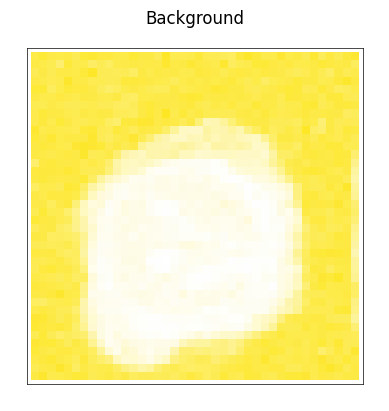

In [56]:
axs = ramanspy.plot.image([abundance_map[..., selected_image_layer] for abundance_map in selected_abundances], title=labels_, cbar=False)

Plotting a merged reconstruction of the selected image slice by plotting the abundance maps in one plot.



/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_34816/1359959341.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))


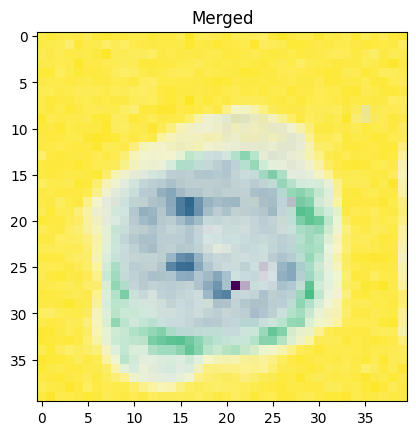

In [57]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))

white = [1, 1, 1, 0]

order = ['Background', 'Cytoplasm', 'Nucleus', 'Lipids']
for label in order:
    i = labels_.index(label)
    ax.imshow(selected_abundances[i][..., selected_image_layer], cmap=LinearSegmentedColormap.from_list('', [white, cmap[i]]))

ax.set_title('Merged')

plt.show()

## References
.. [1] Kallepitis, C., Bergholt, M., Mazo, M. et al. Quantitative volumetric Raman imaging of three dimensional cell cultures. Nat Commun 8, 14843 (2017).

.. [2] Winter ME. N-FINDR: An algorithm for fast autonomous spectral end-member determination in hyperspectral data. InImaging Spectrometry V 1999 Oct 27 (Vol. 3753, pp. 266-275). SPIE.

.. [3] Heinz DC. Fully constrained least squares linear spectral mixture analysis method for material quantification in hyperspectral imagery. IEEE transactions on geoscience and remote sensing. 2001 Mar;39(3):529-45.

